In [1]:
!git clone https://github.com/dvg13/molecule

!pip install --pre deepchem
import deepchem as dc
from deepchem.feat.mol_graphs import ConvMol

Cloning into 'molecule'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 53 (delta 20), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (53/53), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 32.6 MB/s 
     |████████████████████████████████| 36.8 MB 1.2 MB/s 


In [2]:
cd molecule


/content/molecule


In [15]:
import tensorflow as tf
from tensorflow import keras

import gnn
import nmgnn
import convmol_dataloader as dl
import metrics

In [4]:
import importlib
importlib.reload(gnn)
importlib.reload(nmgnn)
importlib.reload(dl)

<module 'convmol_dataloader' from '/content/molecule/convmol_dataloader.py'>

In [5]:
#load data - use scaffold split

In [6]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv', splitter='scaffold')
train_dataset, valid_dataset, test_dataset = datasets

In [ ]:
#this will pad the molecules to be the same length - so that needs to be the longest thing we'll see

In [7]:
max_atoms = max([dl.get_max_atoms(train_dataset), dl.get_max_atoms(valid_dataset), dl.get_max_atoms(test_dataset)])

In [8]:
train_cmg = dl.ConvMolGenerator(train_dataset, batch_size=5, max_atoms=max_atoms)
valid_cmg = dl.ConvMolGenerator(valid_dataset, batch_size=5, max_atoms=max_atoms)

In [ ]:
#we can load the whole dataset in memory

In [9]:
features,adj,labels = dl.ConvMolGenerator(train_dataset, max_atoms=max_atoms).get_in_memory_vectors()
valid_features, valid_adj, valid_labels = dl.ConvMolGenerator(valid_dataset, max_atoms=max_atoms).get_in_memory_vectors()

/content/molecule/convmol_dataloader.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_array[old_array_slices] = array


In [ ]:
#base gcn model

In [16]:
model = gnn.ATOM_GCN(max_atoms, 75, 12, use_symmetric_mean=True)
model.compile(tf.keras.optimizers.Adam(0.001), loss=keras.losses.binary_crossentropy)

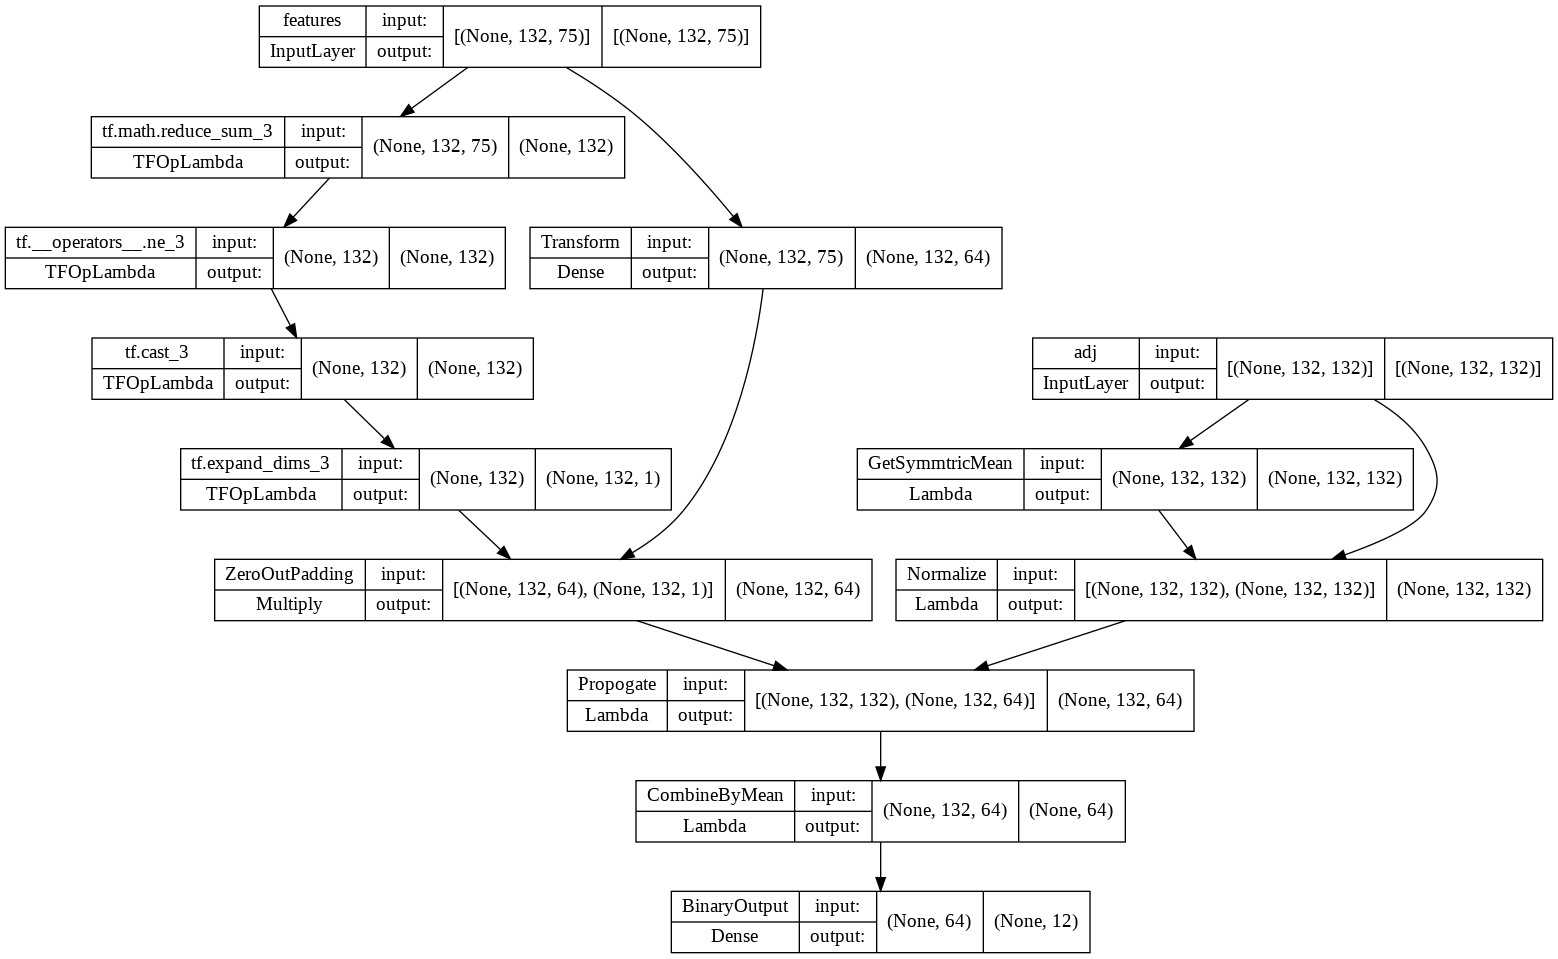

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
#model.fit(train_cmg, epochs=10, validation_data=valid_cmg)
model.fit(x=[features,adj], y=labels, epochs=50, batch_size=10, 
          validation_data=([valid_features,valid_adj], valid_labels))



Epoch 1/50
627/627 [==============================] - 9s 7ms/step - loss: 0.2399 - val_loss: 0.2482
Epoch 2/50
627/627 [==============================] - 3s 4ms/step - loss: 0.2057 - val_loss: 0.2473
Epoch 3/50
627/627 [==============================] - 3s 5ms/step - loss: 0.2026 - val_loss: 0.2454
Epoch 4/50
627/627 [==============================] - 3s 5ms/step - loss: 0.1997 - val_loss: 0.2421
Epoch 5/50
627/627 [==============================] - 5s 8ms/step - loss: 0.1972 - val_loss: 0.2405
Epoch 6/50
627/627 [==============================] - 3s 5ms/step - loss: 0.1957 - val_loss: 0.2449
Epoch 7/50
627/627 [==============================] - 4s 7ms/step - loss: 0.1945 - val_loss: 0.2422
Epoch 8/50
627/627 [==============================] - 5s 7ms/step - loss: 0.1937 - val_loss: 0.2431
Epoch 9/50
627/627 [==============================] - 4s 7ms/step - loss: 0.1930 - val_loss: 0.2382
Epoch 10/50
627/627 [==============================] - 5s 8ms/step - loss: 0.1926 - val_loss: 0.2438

In [20]:
test_cmg = dl.ConvMolGenerator(test_dataset, max_atoms=max_atoms)


In [21]:
test_features, test_adj, test_labels = dl.ConvMolGenerator(test_dataset, max_atoms=max_atoms).get_in_memory_vectors()

/content/molecule/convmol_dataloader.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_array[old_array_slices] = array


In [22]:
model.evaluate([test_features, test_adj], test_labels)

25/25 [==============================] - 0s 5ms/step - loss: 0.2306


0.23056788742542267

In [ ]:
#metrics for train set

+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|                     | Average |  1   |  2   |  3   |  4   |  5   |  6   |  7   |  8   |  9   |  10  |  11  |  12  |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|  Average Precision  |   0.29  | 0.38 | 0.40 | 0.39 | 0.08 | 0.27 | 0.29 | 0.14 | 0.26 | 0.13 | 0.22 | 0.34 | 0.17 |
|   Top 20 Precision  |   0.53  | 0.65 | 0.65 | 0.70 | 0.10 | 0.65 | 0.85 | 0.35 | 0.60 | 0.35 | 0.60 | 0.45 | 0.35 |
| False negative rate |   0.06  | 0.04 | 0.03 | 0.09 | 0.03 | 0.10 | 0.05 | 0.02 | 0.11 | 0.03 | 0.04 | 0.11 | 0.04 |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+


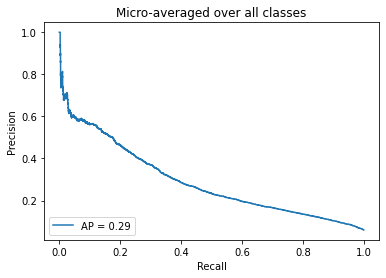

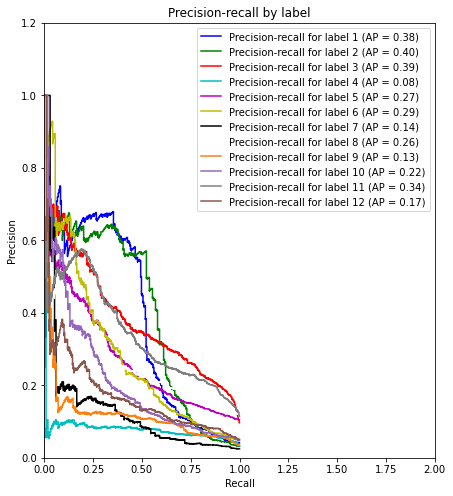

In [25]:
metrics.get_multilabel_stats(model, [features, adj], labels.numpy())

In [ ]:
#metrics for test set

+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|                     | Average |  1   |  2   |  3   |  4   |  5   |  6   |  7   |  8   |  9   |  10  |  11  |  12  |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+
|  Average Precision  |   0.20  | 0.22 | 0.22 | 0.34 | 0.10 | 0.19 | 0.10 | 0.04 | 0.22 | 0.11 | 0.13 | 0.25 | 0.23 |
|   Top 20 Precision  |   0.27  | 0.35 | 0.30 | 0.50 | 0.15 | 0.40 | 0.20 | 0.00 | 0.40 | 0.15 | 0.10 | 0.30 | 0.45 |
| False negative rate |   0.07  | 0.03 | 0.02 | 0.11 | 0.06 | 0.09 | 0.03 | 0.03 | 0.15 | 0.04 | 0.06 | 0.12 | 0.09 |
+---------------------+---------+------+------+------+------+------+------+------+------+------+------+------+------+


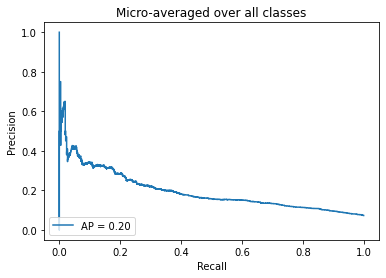

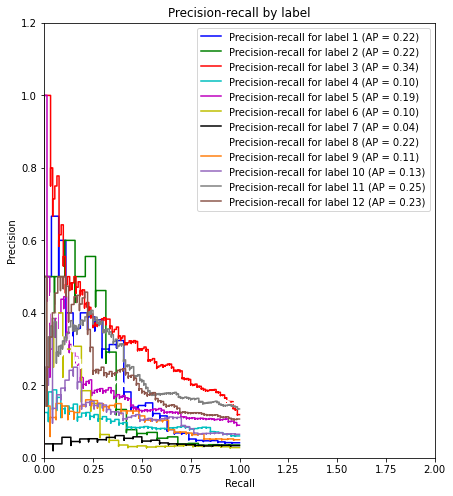

In [24]:
metrics.get_multilabel_stats(model, [test_features, test_adj], test_labels.numpy())